In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
from langchain_groq import ChatGroq

In [8]:
llm = ChatGroq(model="openai/gpt-oss-20b", api_key=os.getenv("groq_api_key"))

In [9]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results = 2)

creating custom tool

In [11]:
def multiply(a:int, b:int) -> int:
    """ Multiply two integers use only if asked to calculate a product of 2 numbers.
    
    Args:
        a (int): first int
        b (int): second int
    
    Returns:
        int: output int
    """
    
    return a*b

In [12]:
tools = [tool,multiply]
llm_with_tools = llm.bind_tools(tools)

In [13]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [14]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [19]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [20]:
def tools_call_llm(state: State) -> str:     #return type string
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [21]:
graph_builder = StateGraph(State)
#adding node
graph_builder.add_node("chatbot", tools_call_llm)
graph_builder.add_node("toolnode", ToolNode(tools))
#adding edges
graph_builder.add_edge(START,"chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "toolnode",
        "end": END
    }
)
graph_builder.add_edge("toolnode",END)
#compiling and building object
graph = graph_builder.compile()

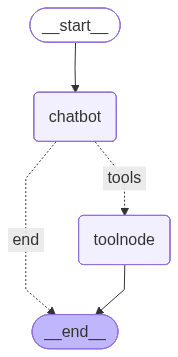

In [22]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
response = graph.invoke({"messages" : "give me latest weather report for ludhiana"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

give me latest weather report for ludhiana
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_e67f1979-47bd-4cdb-ac51-0f120b2826be)
 Call ID: fc_e67f1979-47bd-4cdb-ac51-0f120b2826be
  Args:
    query: latest weather report Ludhiana
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest weather report Ludhiana", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.weather25.com/asia/india/punjab/ludhiana?page=month&month=November", "title": "Ludhiana weather in November 2025 - Weather25.com", "content": "weather25.com\nSearch\nweather in India\nRemove from your favorite locations\nAdd to my locations\nShare\nweather in India\n\n# Ludhiana weather in November 2025\n\nClear\nClear\nPartly cloudy\nCle

In [26]:
response = graph.invoke({"messages" : "what is 7 multiplied by 12"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is 7 multiplied by 12
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_71d387a5-06e1-41ad-add8-007d47984288)
 Call ID: fc_71d387a5-06e1-41ad-add8-007d47984288
  Args:
    a: 7
    b: 12
================================= Tool Message =================================
Name: multiply

84


In [27]:
graph_builder = StateGraph(State)
#adding node
graph_builder.add_node("chatbot", tools_call_llm)
graph_builder.add_node("toolnode", ToolNode(tools))
#adding edges
graph_builder.add_edge(START,"chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "toolnode",
        "__end__": END
    }
)
graph_builder.add_edge("toolnode","chatbot")
#compiling and building object
graph = graph_builder.compile()

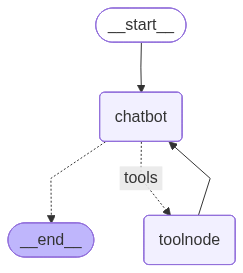

In [28]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
response = graph.invoke({"messages" : "what is 7 multiplied by 12 and give latest news about india"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is 7 multiplied by 12 and give latest news about india
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_1ac5c138-6885-420b-8f01-286be5308f76)
 Call ID: fc_1ac5c138-6885-420b-8f01-286be5308f76
  Args:
    a: 7
    b: 12
================================= Tool Message =================================
Name: multiply

84
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_4550c75f-bd80-48a0-ad8c-689a2577d74f)
 Call ID: fc_4550c75f-bd80-48a0-ad8c-689a2577d74f
  Args:
    query: latest news India
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news India", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://energy.econom

In [30]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_builder = StateGraph(State)
#adding node
graph_builder.add_node("chatbot", tools_call_llm)
graph_builder.add_node("toolnode", ToolNode(tools))
#adding edges
graph_builder.add_edge(START,"chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {
        "tools": "toolnode",
        "__end__": END
    }
)
graph_builder.add_edge("toolnode","chatbot")
#compiling and building object with memory
graph = graph_builder.compile(checkpointer=memory)

In [37]:
config = {"configurable" : {"thread_id" : "1"}}
config2 = {"configurable" : {"thread_id" : "2"}}

In [35]:
response = graph.invoke({"messages":"My name is Rahul and i live in Ludhiana"},config=config)
print(response["messages"][-1].content)

Got it—Rahul from Ludhiana. How can I help you today? If you have a question or need information on anything, just let me know!


In [36]:
response = graph.invoke({"messages":"what is my name and where do i live?"},config=config)
print(response["messages"][-1].content)

You’re Rahul, and you live in Ludhiana.


In [38]:
response = graph.invoke({"messages":"My name is Jack and i live in US"},config=config2)
print(response["messages"][-1].content)

Hello Jack! Nice to meet you. How can I help you today?


In [39]:
response = graph.invoke({"messages":"what is my name and where do i live?"},config=config2)
print(response["messages"][-1].content)

You’re Jack, and you live in the United States.
